In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Transform the data to torch tensors and normalize it
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 to match the original LeNet-5 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and test sets
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

device = "cuda"
# Split training set for training and validation
num_train = len(train_set)
indices = list(range(num_train))
split = int(0.8 * num_train)  # 80% for training, 20% for validation

train_indices, val_indices = indices[:split], indices[split:]
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Data loaders
batch_size = 128

train_loader = DataLoader(train_set, batch_size=128, sampler=train_sampler)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)
val_loader = DataLoader(train_set, batch_size=128, sampler=val_sampler)

# Define the LeNet-5 architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=0)  # Convolutional layer with 6 filters of size 5x5
        self.tanh1 = nn.Tanh()  # Tanh activation function
        self.avgpool1 = nn.AvgPool2d(2, stride=2)  # Average pooling layer with size 2x2 and stride 2
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)  # Second convolutional layer with 16 filters of size 5x5
        self.tanh2 = nn.Tanh()  # Tanh activation function
        self.avgpool2 = nn.AvgPool2d(2, stride=2)  # Average pooling layer
        self.conv3 = nn.Conv2d(16, 120, 5, padding=0)  # Third convolutional layer
        self.tanh3 = nn.Tanh()  # Tanh activation function
        self.fc1 = nn.Linear(120, 84)  # Fully connected layer
        self.tanh4 = nn.Tanh()  # Tanh activation function
        self.fc2 = nn.Linear(84, 10)  # Output layer with 10 units for 10 classes
        self.softmax = nn.Softmax(dim=1)  # Softmax activation function
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh1(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.tanh2(x)
        x = self.avgpool2(x)
        x = self.conv3(x)
        x = self.tanh3(x)
        x = x.view(-1, 120)  # Flatten the tensor for the fully connected layers
        x = self.fc1(x)
        x = self.tanh4(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [11]:
device = "cuda"

# Initialize the network
model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train(model, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(train_loader, unit="batch") as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss/len(train_loader))
        validate(model, epoch)
        
# Test the model
def test(model):
    model.eval()
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            correct = 0
            total = 0
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                tepoch.set_description("Testing")
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')
        

def validate(model, epoch):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(), tqdm(val_loader, unit="batch") as vepoch:
        for images, labels in vepoch:
            images, labels = images.to(device), labels.to(device)
            vepoch.set_description(f"Epoch {epoch+1}/Validation")
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        vepoch.set_postfix(validation_accuracy=accuracy)

In [12]:
# Run training and testing
train(model, num_epochs=5)

Epoch 5/Validation: 100%|██████████| 94/94 [00:01<00:00, 90.23batch/s]


In [6]:
test(model)

Testing: 100%|██████████| 79/79 [00:00<00:00, 94.18batch/s]

Accuracy of the model on the 10000 test images: 97.98%


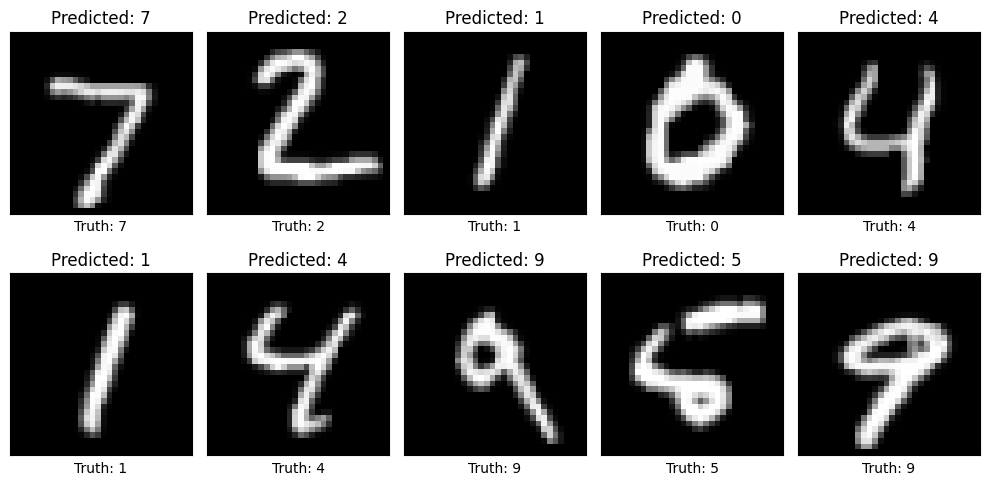

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images, predictions, and truths
def plot_images(images, labels, preds):
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        plt.subplot(2, 5, i + 1)
        image = image.numpy().squeeze()
        plt.imshow(image, cmap='gray')
        plt.title(f'Predicted: {preds[i]}')
        plt.xlabel(f'Truth: {labels[i]}')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

# Select a few random test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Convert predictions and labels to lists
preds = predicted.cpu().numpy()
labels = labels.cpu().numpy()
images = images.cpu()
# Plot the results
plot_images(images[:10], labels[:10], preds[:10])


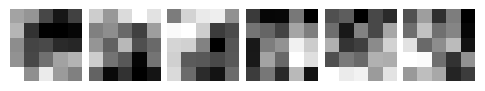

In [45]:
import matplotlib.pyplot as plt

def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("The tensor should be 4D")
    
    num_kernels = tensor.shape[0]
    num_rows = num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))
    
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)
        ax1.imshow(tensor[i][0].cpu().detach(), cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Assuming 'model' is your LeNet instance and is loaded with trained weights
# Conv1 weights
plot_kernels(model.conv1.weight.data)



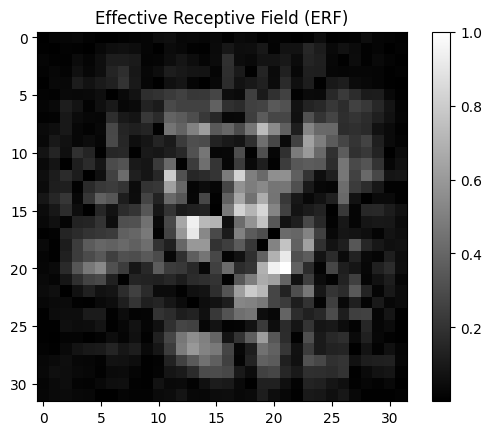

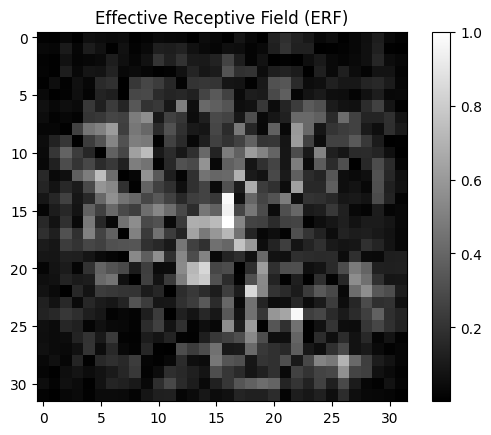

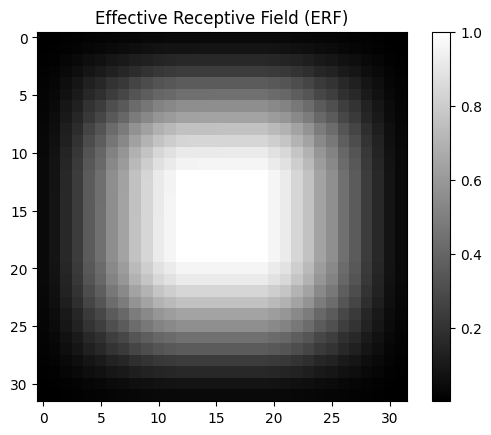

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_erf(model, input_shape=(1, 1, 32, 32), device='cuda', im_name='erf.png'):
    # Initialize the input tensor with zero, set it to require gradients
    input_tensor = torch.zeros(input_shape, device=device, requires_grad=True)
    # input_tensor = torch.randn(input_shape, device=device, requires_grad=True)
    # Set the model to evaluation mode
    model.eval()
    
    # Forward pass: compute the output tensor
    output = model(input_tensor)

    # Initialize the output gradient as zero everywhere and 1 at a specific location
    grad_output = torch.zeros_like(output)
    x = grad_output.shape[2] // 2
    y = grad_output.shape[3] // 2   
    
    for f in range(grad_output.shape[1]):
        grad_output[0, f, x, y] = 1

    # Backward pass: compute gradient of the output with respect to the input image
    output.backward(grad_output)

    # Retrieve the gradient of the input
    grad_input = input_tensor.grad.data[0, 0].cpu().numpy()
    grad_input = np.abs(grad_input)  # Get the absolute values of the gradients
    grad_input = grad_input / (grad_input.max() + 1e-12)  # Normalize the gradients to be between 0 and 1
    
    # Plot the gradient
    plt.imshow(grad_input, cmap='gray', interpolation='nearest')
    plt.imsave(im_name, grad_input, cmap='gray')
    plt.title("Effective Receptive Field (ERF)")
    plt.colorbar()
    plt.show()

# Assume 'model' is your LeNet or similar model already loaded and to the appropriate device
untrained_model = CNN().to(device)
uniform_model = CNN().to(device)

# Set every weight to 1 and biases to 0
for param in uniform_model.parameters():
    if param.requires_grad:
        if len(param.shape) > 1:  # This is a weight tensor
            nn.init.constant_(param, 1)
        else:  # This is a bias tensor
            nn.init.constant_(param, 0) 

# Assuming 'model' is already defined and moved to appropriate device
visualize_erf(model, im_name='erf_trained.png')
visualize_erf(untrained_model, im_name='erf_untrained.png')
visualize_erf(uniform_model, im_name='erf_uniform.png')

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Assuming model is your CNN model which has already been defined and loaded

def save_filters(model):
    # Create a directory to store the filter images
    if not os.path.exists('filters'):
        os.makedirs('filters')
    
    layer_index = 1
    # Iterate over each module in the model
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            weights = module.weight.data.cpu().numpy()  # Get the filter weights
            n_filters = weights.shape[0]  # Number of filters in the convolutional layer
            
            # Process each filter
            for i in range(n_filters):
                filter = weights[i, 0]  # Get the ith filter. Assumes the input channel is 1.
                filter = (filter - np.min(filter)) / (np.max(filter) - np.min(filter))  # Normalize to [0, 1]
                
                # Save the filter as an image
                plt.imshow(filter, cmap='gray')
                plt.axis('off')  # Turn off axis
                plt.savefig(f'filters/filter_layer{layer_index}_{i}.png', bbox_inches='tight', pad_inches=0)
                plt.close()  # Close the plot to avoid display overhead
                
            layer_index += 1  # Increment to move to the next layer

# Assuming 'model' is your CNN instance
save_filters(model)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NoPoolingCNN(nn.Module):
    def __init__(self):
        super(NoPoolingCNN, self).__init__()
        # Input size: [1, 28, 28] (standard MNIST images)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)  # Maintains size [32, 28, 28]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)  # Output size [64, 14, 14]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)  # Output size [128, 7, 7]
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)  # Output size [256, 4, 4]
        self.fc1 = nn.Linear(256 * 4 * 4, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 10)  # Output layer, 10 classes for MNIST
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(-1, 256 * 4 * 4)  # Flatten the features for fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model instance
model_nopooling = NoPoolingCNN().to(device)

train(model_nopooling, num_epochs=5)
# Print the model architecture
print(model)


  0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 5/Validation: 100%|██████████| 94/94 [00:02<00:00, 33.10batch/s]

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (tanh1): Tanh()
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (tanh2): Tanh()
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (tanh3): Tanh()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (tanh4): Tanh()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


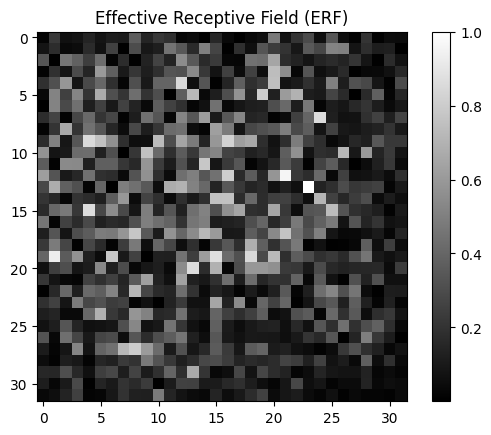

In [ ]:
visualize_erf(model_nopooling)

NameError: name 'torch' is not defined